# Working code : Do not change

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import*

In [2]:
I2 = np.matrix([[1,0],
                [0,1]])
hadamard_gate  = np.matrix([[1,1],
                [1,-1]])* (1/np.sqrt(2))
phase_gate  = np.matrix([[1,0],
                [0,1j]])
sigma_x  = np.matrix([[0,1],
                [1,0]])
sigma_y  = np.matrix([[0,-1j],
                [1j,0]])
sigma_z  = np.matrix([[1,0],
                [0,-1]])

In [3]:
def Minv(N_qubits,X):
    return ((2**N_qubits+1.))*X - np.eye(2**N_qubits)

In [4]:
#nShadows = 1000
reps = 1
#rng = np.random.default_rng(1717)

def test_quantum_circuit(N_qubits,angle_1):
    qc_test = QuantumCircuit(N_qubits)
    qc_test.h(0)
    #qc_test.x(1)
    #qc_test.z(2)
    qc_test.cry(angle_1,0,1)
    #qc_test.rx(angle_1,2)
    #qc_test.cx(2,0)
    return qc_test

def shadow_tomography_clifford(N_qubits,quantum_circuit):

    cliffords = [qiskit.quantum_info.random_clifford(N_qubits,) for _ in range(n_Shadows)]
    
    rho_actual = qiskit.quantum_info.DensityMatrix(quantum_circuit).data
    
    results = []
    for cliff in cliffords:
        qc_c  = quantum_circuit.compose(cliff.to_circuit())

        counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(reps)
        results.append(counts)
        
    shadows = []
    for cliff, res in zip(cliffords, results):
        mat    = cliff.adjoint().to_matrix()
        for bit,count in res.items():
            Ub = mat[:,int(bit,2)] # this is Udag|b>
            shadows.append(Minv(N_qubits,np.outer(Ub,Ub.conj()))*count)

    #rho_shadow = np.sum(shadows,axis=0)/(nShadows*reps)
    return rho_actual,shadows#shadows

In [5]:
def linear_function_prediction(N,K,operator_linear,list_of_shadows):
    list_of_means = []
    
    # calculating K means
    for k in range(1,K+1):
        shadows_mean = 0.0
        for j in range(N*(k-1)+1,N*k+1):
            rho_j = list_of_shadows[j-1]
            shadows_mean += np.trace(operator_linear@rho_j )
            
        list_of_means.append(shadows_mean/N)
        
    # calculating the median of K means
    return np.median(list_of_means)

def quadratic_function_prediction(N,K,operator_m,operator_n,list_of_shadows):
    
    list_of_means = []
    
    SWAP = np.matrix([[1,0,0,0],
                      [0,0,1,0],
                      [0,1,0,0],
                      [0,0,0,1]])
    r"""
    
    calculating the operator O. Note that the order of operator_m and operator_n is irrelevant.
    
    """
    
    O_quadratic = SWAP@np.kron(operator_m,operator_n)
    
    # calculating K means
    for k in range(1,K+1):
        shadows_mean = 0.0        
        for j in range(N*(k-1)+1,N*k+1):
            for l in range(N*(k-1)+1,N*k+1):
                if j != l:
                    rho_j = list_of_shadows[j-1]
                    rho_l = list_of_shadows[l-1]
                    shadows_mean += np.trace(O_quadratic@np.kron(rho_j,rho_l))
                    
        list_of_means.append(shadows_mean/(N*(N-1)))
        
    # calculating their median
    return np.median(list_of_means)

In [6]:
np.sqrt(1000)

31.622776601683793

In [15]:
N = 40
K = 10
N_qubits = 2
n_Shadows = N*K
number_of_angle_divisons = 20
angles_lst = np.linspace(0.0,2*np.pi,number_of_angle_divisons)
number_of_repetitions = 10
"""
for angle_index in range(len(angles_lst)):
    for repetitions in range(number_of_repetitions):
        st_instance = shadow_tomography_clifford(N_qubits,test_quantum_circuit(N_qubits,angles_lst[angle_index]))
        path = "/Users/sasankadowarah/Ultimate_QM_MM/shadows_data/multi_qubit_data/30_30_10_10_2"
        os.chdir("/Users/sasankadowarah/Ultimate_QM_MM/shadows_data/multi_qubit_data/30_30_10_10_2") 
        np.save("exact_density_matrix_"+str(N*K)+"_"+str(repetitions)+"_"+str(angle_index)+".npy",st_instance[0])    
        np.save("shadow_density_matrix_"+str(N*K)+"_"+str(repetitions)+"_"+str(angle_index)+".npy",st_instance[1])#""";

In [58]:
"""number_of_angle_divisons = 10
angles_lst = np.linspace(0.0,np.pi/2,number_of_angle_divisons)
number_of_repetitions = 10"""
operator_1 = I2#np.kron(sigma_x,sigma_x)
operator_2 = sigma_y#np.kron(sigma_z,sigma_x)
operator_3 = np.kron(I2,sigma_y)

# these lists will hold the mean function values of all repetitions
linear_exact_function_values = []
linear_predicted_function_values = []
linear_predicted_values_SEOM = []

quadratic_exact_function_values = []
quadratic_predicted_function_values = []
quadratic_predicted_values_SEOM = []

# calculating the exact and predicted value at each angle
for angle_index in range(len(angles_lst)):
    
    # list to hold linear function values.
    linear_exact_values = []
    linear_predicted_values = []
    
    # list to hold quadratic function values.
    quadratic_exact_values = []
    quadratic_predicted_values = []  
    
    r"""
    
    At each value of angle; N*K shadows are calculated. This process is
    repeated #number_of_repetitions number of times.
    
    """
    # calculating function values for all repetitions
    for repetitions in range(number_of_repetitions):
        
        # loads the shadows and the exact density matrix
        path = "/Users/sasankadowarah/Ultimate_QM_MM/shadows_data/exact_single_qubit/40_10_10_10"
        os.chdir(path)         
        exact_rho = np.load("exact_density_matrix_"+str(N*K)+"_"+str(repetitions)+"_"+str(angle_index)+".npy")    
        shadows_rho_lst = np.load("shadow_density_matrix_"+str(N*K)+"_"+str(repetitions)+"_"+str(angle_index)+".npy") 
        
        # linear
        #linear_exact_values.append(np.trace(operator_3@exact_rho))
        #linear_predicted_values.append(linear_function_prediction(N,K,operator_3,shadows_rho_lst))
        
        # quadratic
        quadratic_exact_values.append(np.trace(operator_1@exact_rho@operator_2@exact_rho))
        quadratic_predicted_values.append(quadratic_function_prediction(N,K,operator_1,operator_2,shadows_rho_lst))
        
    # calculating the mean over all the repetitions    
    #linear_exact_function_values.append(np.mean(linear_exact_values).real) # unnecessary
    #linear_predicted_function_values.append(np.mean(linear_predicted_values).real)
    
    quadratic_exact_function_values.append(np.mean(quadratic_exact_values).real) # unnecessary
    quadratic_predicted_function_values.append(np.mean(quadratic_predicted_values).real)    
    
    # SEOM is calculated in case there are more than one repetitions
    if number_of_repetitions > 1:
        #linear_predicted_values_SEOM.append(np.std(linear_predicted_values)/np.sqrt(number_of_repetitions-1))
        quadratic_predicted_values_SEOM.append(np.std(quadratic_predicted_values)/np.sqrt(number_of_repetitions-1))        
    else:
        pass

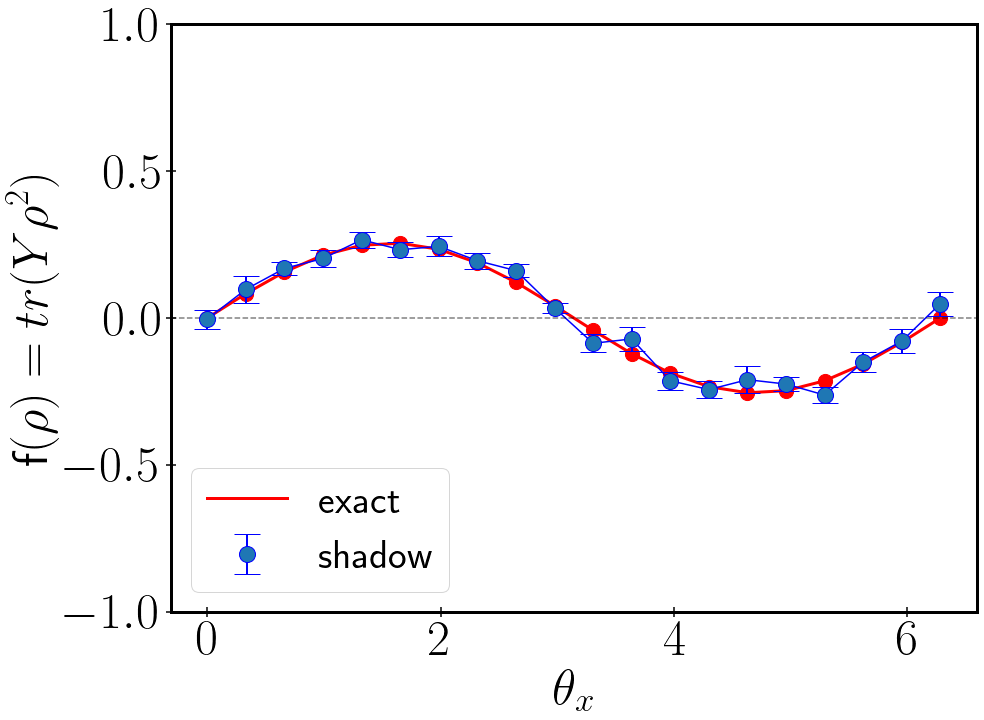

In [68]:
large = 50; med = 40; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': large ,
          'axes.titlesize': med ,
          'xtick.labelsize': large ,
          'ytick.labelsize': large ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
plt.rcParams.update(params)
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(12)

"""# linear plot
plt.plot(angles_lst,linear_exact_function_values,c="red",label="exact",linewidth=3)
plt.scatter(angles_lst,linear_exact_function_values,label="",s = 200,c="red")
plt.plot(angles_lst,linear_predicted_function_values,c="blue")

if len(linear_predicted_values_SEOM) > 0:
    plt.errorbar(angles_lst,linear_predicted_function_values,yerr = linear_predicted_values_SEOM,c="blue",label="shadow",
                fmt="o",mfc="tab:blue",ms = 16,mew=1,capsize=13, elinewidth=2,)
else:    
    pass
    #plt.scatter(angles_lst,linear_predicted_function_values,c="blue",label="shadow",s = 100)
    
#yerr = 0.1
#plt.fill_between(angles_lst, np.array(linear_exact_function_values) - yerr, 
#                 np.array(linear_exact_function_values) + yerr,color="red", alpha=0.2,label=r"$\epsilon = $" + str(yerr))""";

# quadratic
plt.plot(angles_lst,quadratic_exact_function_values,c="red",label="exact",linewidth=3)
plt.scatter(angles_lst,quadratic_exact_function_values,label="",s = 200,c="red")
plt.plot(angles_lst,quadratic_predicted_function_values,c="blue")

if len(quadratic_predicted_values_SEOM) > 0:
    plt.errorbar(angles_lst,quadratic_predicted_function_values,yerr = quadratic_predicted_values_SEOM,
                c="blue",label="shadow",
                fmt="o",mfc="tab:blue",ms = 16,mew=1,capsize=13, elinewidth=2,)
else:    
    pass
    #plt.scatter(angles_lst,linear_predicted_function_values,c="blue",label="shadow",s = 100)
    
#yerr = 0.1
#plt.fill_between(angles_lst, np.array(quadratic_exact_function_values) - yerr, 
#                 np.array(quadratic_exact_function_values) + yerr,color="red", alpha=0.2,label=r"$\epsilon = $" + str(yerr))
ax = f.gca()
#ax.axvline(theta_x_exact, color="green",label=r"Exact $\theta_{x}$",linestyle="--")
ax.axhline(0, color="k",linestyle="--",alpha=0.5)
#ax.axvline(theta_y_exact, color="green",label = r"$\theta_{x}$",linestyle="--")
#plt.title("Plot of cost function, "+r"$f( \rho ) = \textrm{tr}((\mathcal{L}\rho)^{2})$")
#plt.title(r"N_{\textrm{qubits} = "+str(N_qubits)+", N_shadows = "+str(N*K))
plt.xlabel(r"$\theta_{x}$")
plt.ylabel(r"f$(\rho ) = tr( Y\rho^{2})$")
plt.ylim([-1,1])
plt.legend(loc="lower left")
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.2)
# Set the linewidth of the spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)  # Change the value to adjust thickness 
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1.5, color="k")
path = "/Users/sasankadowarah/Ultimate_QM_MM"
os.chdir(path) 
import time
#plt.savefig("f_as_function_of_theta_x_"+str(N)+"_"+str(K)+"_"+str(number_of_repetitions)+"_"+str(time.time())+".jpg",dpi=300)
plt.savefig("quadratic_2_as_function_of_theta_x_"+str(N)+"_"+str(K)+"_"+str(number_of_repetitions)+".jpg",dpi=300)
plt.show()

In [60]:
"""qc = test_quantum_circuit(4,np.pi/4)
rho_actual = qiskit.quantum_info.DensityMatrix(qc).data
rho_shadow = shadow_tomography_clifford(4,qc)

plt.subplot(121)
plt.suptitle("Correct")
plt.imshow(rho_actual.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_actual.imag,vmax=0.7,vmin=-0.7)
plt.show()
print("---")

plt.subplot(121)
plt.suptitle("Shadow(Full Clifford)")
plt.imshow(rho_shadow.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_shadow.imag,vmax=0.7,vmin=-0.7)
plt.show()""";

In [61]:
#qiskit.visualization.state_visualization.plot_state_city(rho_actual,title="Correct")

In [62]:
#qiskit.visualization.state_visualization.plot_state_city(rho_shadow,title="Shadow (clifford)")

## Pauli

Repeating the above, but now with a Pauli string. Note this is effectively the same as single qubit Cliffords

In [63]:
"""nShadows = 10_000
N = 2

rng = np.random.default_rng(1717)
scheme = [rng.choice(['X','Y','Z'],size=N) for _ in range(nShadows)]
labels, counts = np.unique(scheme,axis=0,return_counts=True)
    
qc = qiskit.QuantumCircuit(N)
channel(N,qc)

results = []
for bit_string,count in zip(labels,counts):
    qc_m = qc.copy() 
    # rotate the basis for each qubit
    for i,bit in enumerate(bit_string): bitGateMap(qc_m,bit,i) 
    counts = qiskit.quantum_info.Statevector(qc_m).sample_counts(count)
    results.append(counts)""";

Note: qiskit using little-endian encoding so $X_1|00\rangle = |10\rangle$

In [64]:
"""def rotGate(g):
    '''produces gate U such that U|psi> is in Pauli basis g'''
    if g=="X":
        return 1/np.sqrt(2)*np.array([[1.,1.],[1.,-1.]])
    elif g=="Y":
        return 1/np.sqrt(2)*np.array([[1.,-1.0j],[1.,1.j]])
    elif g=="Z":
        return np.eye(2)
    else:
        raise NotImplementedError(f"Unknown gate {g}")""";      

In [65]:
"""shadows = []
shots = 0
for pauli_string,counts in zip(labels,results):
    # iterate over measurements
     for bit,count in counts.items():
        mat = 1.
        for i,bi in enumerate(bit[::-1]):
            b = rotGate(pauli_string[i])[int(bi),:]
            mat = np.kron(Minv(1,np.outer(b.conj(),b)),mat)
        shadows.append(mat*count)
        shots+=count

rho_shadow = np.sum(shadows,axis=0)/(shots)""";

In [66]:
"""rho_actual = qiskit.quantum_info.DensityMatrix(qc).data


plt.subplot(121)
plt.suptitle("Correct")
plt.imshow(rho_actual.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_actual.imag,vmax=0.7,vmin=-0.7)
plt.show()
print("---")

plt.subplot(121)
plt.suptitle("Shadow(Pauli)")
plt.imshow(rho_shadow.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_shadow.imag,vmax=0.7,vmin=-0.7)
plt.show()""";